Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [11]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# Training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed = 123,
                                                               validation_split = 0.2,
                                                               image_size = (img_height,img_width),
                                                               batch_size= batch_size,
                                                               subset = "training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split = 0.2,
                                                             image_size = (img_height,img_width),
                                                             batch_size = batch_size,
                                                             subset = "validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List of class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


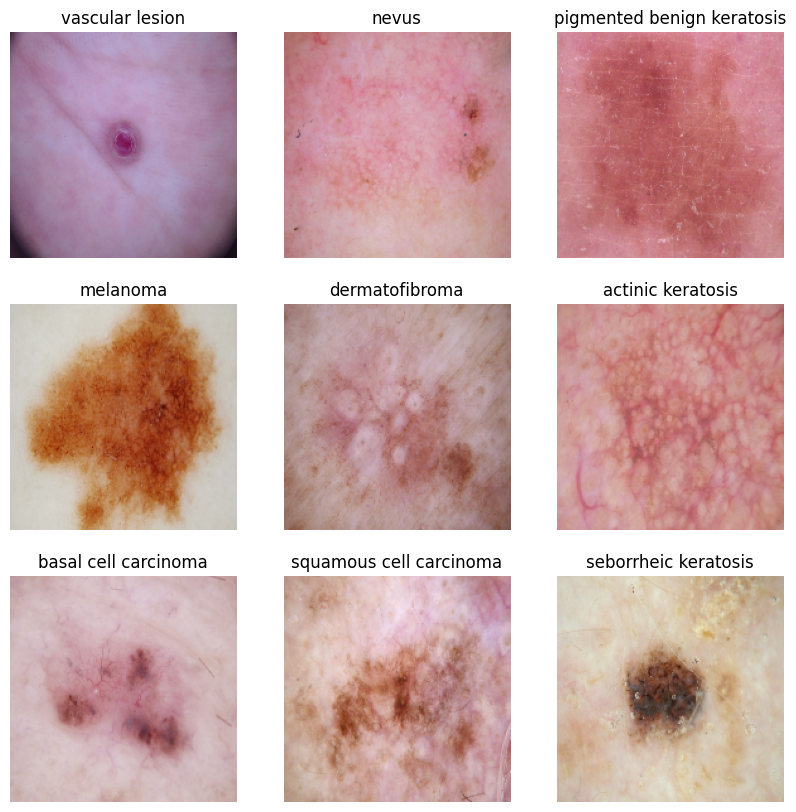

In [9]:
seen_classes = {class_name: False for class_name in class_names}
num_classes_seen = 0
plt.figure(figsize=(10,10))
for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if not seen_classes[class_name]:
            plt.subplot(3, 3, num_classes_seen + 1)
            image = image.numpy().astype("uint8")
            plt.imshow(image)
            plt.title(class_name)
            plt.axis("off")
            seen_classes[class_name] = True
            num_classes_seen += 1
            if num_classes_seen == len(class_names):
                break
    if num_classes_seen == len(class_names):
        break
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model

In [11]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))

### Compile the model

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        9280      
                                                                 
 activation (Activation)     (None, 90, 90, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 90, 90, 64)        256       
 Normalization)                                         

### Train the model

In [14]:
# Encoding the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, 9)
    return image, label

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [17]:
# Model Fitting
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 682s 8s/step - loss: 35.3047 - accuracy: 0.2623 - val_loss: 38.0944 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 308s 6s/step - loss: 18.4210 - accuracy: 0.2885 - val_loss: 24.9320 - val_accuracy: 0.1544
Epoch 3/20
56/56 [==============================] - 293s 5s/step - loss: 13.1939 - accuracy: 0.3030 - val_loss: 21.7006 - val_accuracy: 0.0671
Epoch 4/20
56/56 [==============================] - 298s 5s/step - loss: 9.1913 - accuracy: 0.3242 - val_loss: 16.8253 - val_accuracy: 0.0805
Epoch 5/20
56/56 [==============================] - 292s 5s/step - loss: 6.4984 - accuracy: 0.3393 - val_loss: 12.0440 - val_accuracy: 0.0626
Epoch 6/20
56/56 [==============================] - 298s 5s/step - loss: 4.7884 - accuracy: 0.3616 - val_loss: 8.1223 - val_accuracy: 0.1298
Epoch 7/20
56/56 [==============================] - 293s 5s/step - loss: 3.8253 - accuracy: 0.3555 - val_loss: 4.1031 - val_accuracy: 0.2707
Epoch

### Visualizing training results

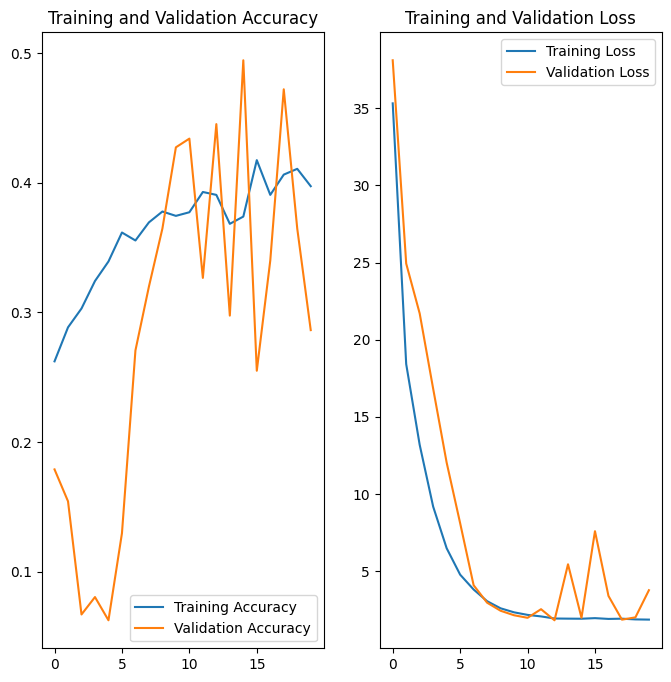

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model seems to overfit the data.
#### The training loss consistently decreased, while the validation loss and accuracy fluctuated significantly after initial improvements.

## Data Augmentation

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir_train,
    seed = 123,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

val_generator = val_datagen.flow_from_directory(
    data_dir_train,
    seed = 123,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


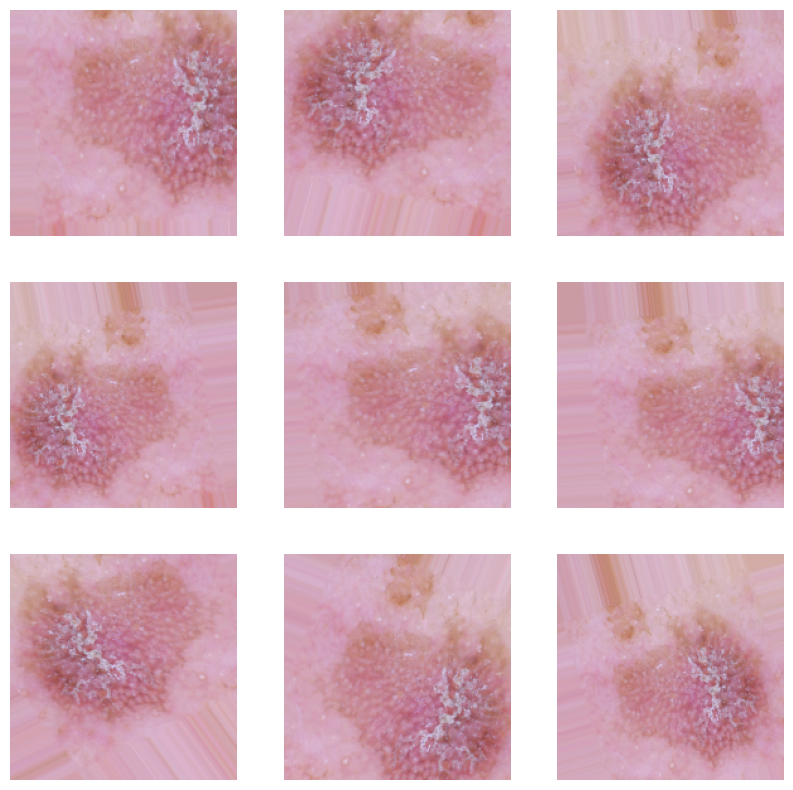

In [29]:
# Visulaizing the changes after data augmentation
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img


img_path = '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026709.jpg'
img = load_img(img_path, target_size=(img_height, img_width))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_images = datagen.flow(x, batch_size=1)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_image = next(augmented_images)[0]
    plt.imshow(augmented_image)
    plt.axis('off')

plt.show()


### Creating the model, compiling and training the model


In [30]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))


### Compiling the model

In [31]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        9280      
                                                                 
 activation_6 (Activation)   (None, 90, 90, 64)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 90, 90, 64)        256       
 chNormalization)                                     

### Training the model

In [33]:
history = model.fit(
  train_generator,
  validation_data=val_generator,
  epochs=20
)

Epoch 1/20
57/57 [==============================] - 337s 6s/step - loss: 33.5458 - accuracy: 0.2384 - val_loss: 76.5959 - val_accuracy: 0.0428
Epoch 2/20
57/57 [==============================] - 328s 6s/step - loss: 17.2547 - accuracy: 0.2318 - val_loss: 67.9347 - val_accuracy: 0.0428
Epoch 3/20
57/57 [==============================] - 344s 6s/step - loss: 12.3766 - accuracy: 0.2111 - val_loss: 44.2097 - val_accuracy: 0.0428
Epoch 4/20
57/57 [==============================] - 325s 6s/step - loss: 8.9000 - accuracy: 0.2061 - val_loss: 24.6814 - val_accuracy: 0.0428
Epoch 5/20
57/57 [==============================] - 342s 6s/step - loss: 6.5109 - accuracy: 0.2056 - val_loss: 14.4287 - val_accuracy: 0.0631
Epoch 6/20
57/57 [==============================] - 326s 6s/step - loss: 4.9714 - accuracy: 0.2061 - val_loss: 12.5378 - val_accuracy: 0.0608
Epoch 7/20
57/57 [==============================] - 340s 6s/step - loss: 3.9653 - accuracy: 0.2061 - val_loss: 10.4777 - val_accuracy: 0.0608
Epo

### Visualizing the results

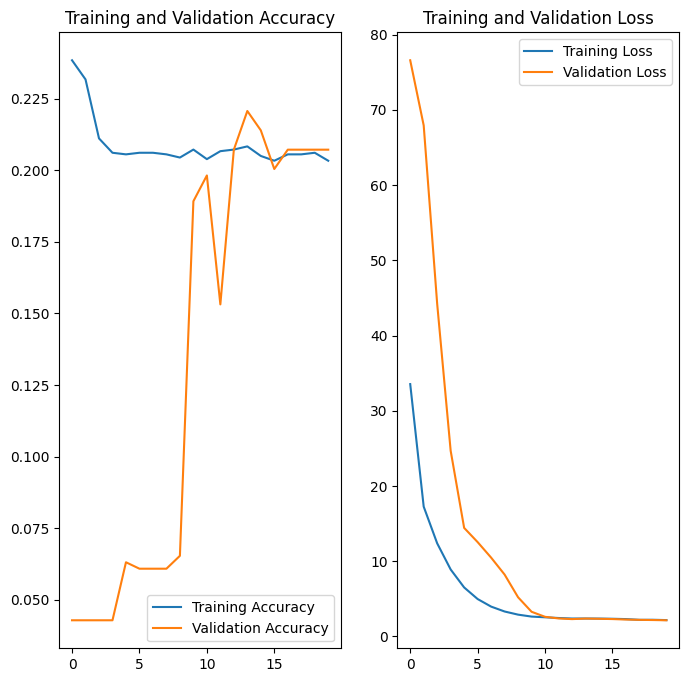

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### There's no overfitting of data and also the loss reduces eventually but the accuray is not significantly increasing.

## Checking Class Imbalance

In [39]:
import collections

class_indices = train_generator.class_indices
index = {i:j for j,i in class_indices.items()}
counter = collections.Counter(train_generator.classes)

class_names_with_count = {index[i]: count for i, count in counter.items()}
print(class_names_with_count)

{'actinic keratosis': 92, 'basal cell carcinoma': 301, 'dermatofibroma': 76, 'melanoma': 351, 'nevus': 286, 'pigmented benign keratosis': 370, 'seborrheic keratosis': 62, 'squamous cell carcinoma': 145, 'vascular lesion': 112}



#### - Which class has the least number of samples?
### **"seborrheic keratosis" has the least number of samples of about 62 samples.**
#### - Which classes dominate the data in terms proportionate number of samples?
### **"pigmented benign keratosis", "basal cell carcinoma" and "melanoma" classes dominate the data.**


In [40]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [51]:
path_to_training_dataset="/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B5CFEB254E0>: 100%|██████████| 500/500 [00:24<00:00, 20.65 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B5CEEF6CD00>: 100%|██████████| 500/500 [00:23<00:00, 21.35 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B5CEEF04040>: 100%|██████████| 500/500 [00:24<00:00, 20.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B5CEEEA1CC0>: 100%|██████████| 500/500 [01:38<00:00,  5.08 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7B5CEF8B0F40>: 100%|██████████| 500/500 [01:35<00:00,  5.21 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B5CEFB7F400>: 100%|██████████| 500/500 [00:22<00:00, 22.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B5CFEABDC60>: 100%|██████████| 500/500 [00:46<00:00, 10.70 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B5CFE8CE710>: 100%|██████████| 500/500 [00:22<00:00, 22.04 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B5CEF051300>: 100%|██████████| 500/500 [00:22<00:00, 22.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [11]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [10]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026729.jpg_b832b4d3-d285-42dc-b1ac-d27b5305ce5d.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027615.jpg_1456defc-f4e8-4606-9c35-037b6c8cb961.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026626.jpg_a8f2b37c-7189-49fb-ba04-70b0c30c0688.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024913.jpg_6ffc19c2-6cb6-446e-b296-fe962a804020.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000360.jpg_b340a0b6-d7f0-411b-9074-15eaa0813317.jpg',
 '/content/drive/MyD

In [12]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [13]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [14]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [15]:
new_df['Label'].value_counts()

Label
nevus                         500
melanoma                      500
seborrheic keratosis          500
squamous cell carcinoma       500
basal cell carcinoma          500
vascular lesion               500
actinic keratosis             500
pigmented benign keratosis    500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Training the model on the data created using Augmentor

In [13]:
batch_size = 32
img_height = 180
img_width = 180

## Creating a training dataset

In [14]:
data_dir_train="/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


## Creating a validation dataset

In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


## Creating Model

In [16]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9))
model.add(layers.Activation('softmax'))


## Compiling model

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training the model

In [18]:
# Encoding the labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, 9)
    return image, label

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs
)

Epoch 1/20
169/169 [==============================] - 1493s 9s/step - loss: 28.7307 - accuracy: 0.2057 - val_loss: 33.0778 - val_accuracy: 0.1047
Epoch 2/20
169/169 [==============================] - 1282s 8s/step - loss: 9.1502 - accuracy: 0.2081 - val_loss: 8.9153 - val_accuracy: 0.0958
Epoch 3/20
169/169 [==============================] - 1222s 7s/step - loss: 4.0138 - accuracy: 0.2170 - val_loss: 2.8476 - val_accuracy: 0.2227
Epoch 4/20
169/169 [==============================] - 1218s 7s/step - loss: 2.5302 - accuracy: 0.2311 - val_loss: 2.1748 - val_accuracy: 0.2777
Epoch 5/20
169/169 [==============================] - 1216s 7s/step - loss: 2.2023 - accuracy: 0.2268 - val_loss: 3.4136 - val_accuracy: 0.2056
Epoch 6/20
169/169 [==============================] - 1220s 7s/step - loss: 2.2134 - accuracy: 0.2333 - val_loss: 5.2075 - val_accuracy: 0.1745
Epoch 7/20
169/169 [==============================] - 1213s 7s/step - loss: 2.1865 - accuracy: 0.2448 - val_loss: 3.4474 - val_accurac

## Visualizing the model results

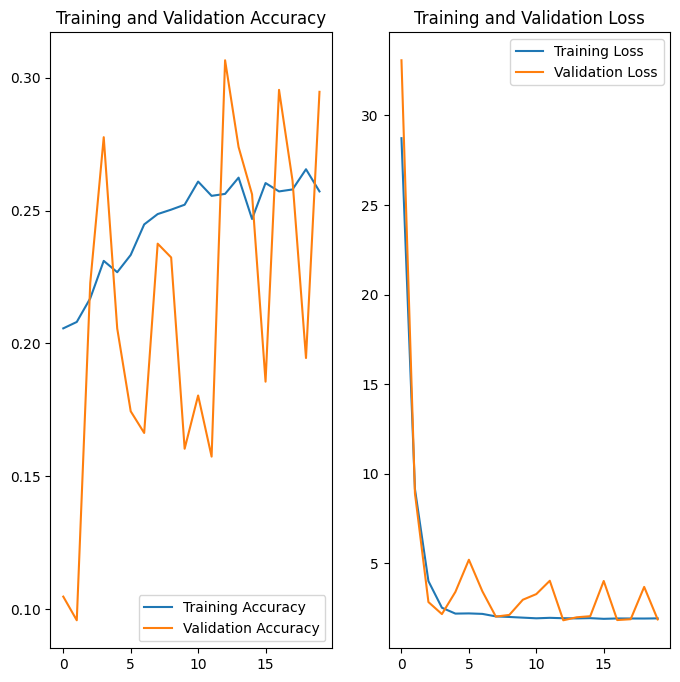

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The class re-balancing didn't help much with overfitting and uderfitting compared to data augmentation. There are a lot of fluctuations in the validation accuracy.

